In [1]:
import geogif
from dask.distributed import Client, LocalCluster
import pystac_client
import stackstac
import xarray as xr
import numpy as np
from pathlib import Path
import dask
from dask.distributed import Lock, Client, LocalCluster
import rioxarray
from rio_cogeo.cogeo import cog_translate
from rio_cogeo.profiles import cog_profiles
from rasterio.io import MemoryFile
from dask.diagnostics import ProgressBar
import zarr
from pathlib import Path
import shutil
from rasterio.enums import Resampling


In [2]:
API_URL   = "https://earth-search.aws.element84.com/v1"
AOI_BBOX  = (-122.6, 37.5, -122.3, 37.9) # San-Francisco Bay
TOI       = "2024-06-01/2024-06-30"
# DESIRED   = ["B04", "B03", "B02"]               # red, green, blue
# CODE_TO_COMMON = {"B02": "blue", "B03": "green", "B04": "red"}
# TARGET_EPSG = 3857                              # Web-Mercator for Leaflet

In [3]:
# Spin up a lightweight local cluster that plays nicely inside notebooks
cluster = LocalCluster(n_workers=4, threads_per_worker=2, memory_limit="8GB")
client  = Client(cluster)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 8,Total memory: 29.80 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:51301,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 8
Started: Just now,Total memory: 29.80 GiB
Comm: tcp://127.0.0.1:51323,Total threads: 2
Dashboard: http://127.0.0.1:51327/status,Memory: 7.45 GiB
Nanny: tcp://127.0.0.1:51305,


In [4]:
catalog = pystac_client.Client.open(API_URL)
search = catalog.search(
    collections=["sentinel-2-l2a"],
    bbox=AOI_BBOX,
    datetime=TOI,
    query={"eo:cloud_cover": {"lt": 20}},      # keep only <20 % cloud
)

In [5]:
items  = search.item_collection()              # still just JSON – no pixels yet
print(f"Matched {len(items)} scenes")

Matched 13 scenes


In [6]:
%%time
DESIRED = ["red", "blue", "green"]
stack = stackstac.stack(items, bounds_latlon=AOI_BBOX,epsg=32610, assets=DESIRED,resolution=100, resampling=Resampling.bilinear)
stack


CPU times: user 8.45 ms, sys: 2.25 ms, total: 10.7 ms
Wall time: 9.58 ms


<xarray.DataArray 'stackstac-c297ceda19bbf7927d29eb76161992b3' (time: 13,
                                                                band: 3,
                                                                y: 446, x: 268)> Size: 37MB
dask.array<fetch_raster_window, shape=(13, 3, 446, 268), dtype=float64, chunksize=(1, 1, 446, 268), chunktype=numpy.ndarray>
Coordinates: (12/53)
  * time                                     (time) datetime64[ns] 104B 2024-...
    id                                       (time) <U24 1kB 'S2A_10SEH_20240...
  * band                                     (band) <U5 60B 'red' 'blue' 'green'
  * x                                        (x) float64 2kB 5.351e+05 ... 5....
  * y                                        (y) float64 4kB 4.195e+06 ... 4....
    s2:medium_proba_clouds_percentage        (time) float64 104B 0.9186 ... 0...
    ...                                       ...
    proj:shape                               object 8B {10980}
    gsd                                      int64 8B 10
    common_name                              (band) <U5 60B 'red' 'blue' 'green'
    center_wavelength                        (band) float64 24B 0.665 0.49 0.56
    full_width_half_max                      (band) float64 24B 0.038 ... 0.045
    epsg                                     int64 8B 32610
Attributes:
    spec:        RasterSpec(epsg=32610, bounds=(535100, 4150400, 561900, 4195...
    crs:         epsg:32610
    transform:   | 100.00, 0.00, 535100.00|\n| 0.00,-100.00, 4195000.00|\n| 0...
    resolution:  100

In [ ]:
stack.band

In [7]:
stack = stack.assign_coords(band=stack.common_name.fillna(stack.band).rename("band"))
stack.band


<xarray.DataArray 'band' (band: 3)> Size: 60B
array(['red', 'blue', 'green'], dtype='<U5')
Coordinates: (12/21)
    s2:sequence                              <U1 4B '0'
    s2:saturated_defective_pixel_percentage  int64 8B 0
    instruments                              <U3 12B 'msi'
    s2:datatake_type                         <U8 32B 'INS-NOBS'
    proj:code                                <U10 40B 'EPSG:32610'
    earthsearch:boa_offset_applied           bool 1B True
    ...                                       ...
    gsd                                      int64 8B 10
    common_name                              (band) <U5 60B 'red' 'blue' 'green'
    center_wavelength                        (band) float64 24B 0.665 0.49 0.56
    full_width_half_max                      (band) float64 24B 0.038 ... 0.045
    epsg                                     int64 8B 32610
  * band                                     (band) <U5 60B 'red' 'blue' 'green'

In [ ]:
rgb = stack.sel(band=["red", "green", "blue"])
monthly_rgb = rgb.resample(time="MS").median(dim="time")
monthly_rgb

In [18]:
%time rgb_ = monthly_rgb.compute()

CPU times: user 1.1 s, sys: 575 ms, total: 1.68 s
Wall time: 28.1 s


In [ ]:
%time rgb_ = rgb.compute()


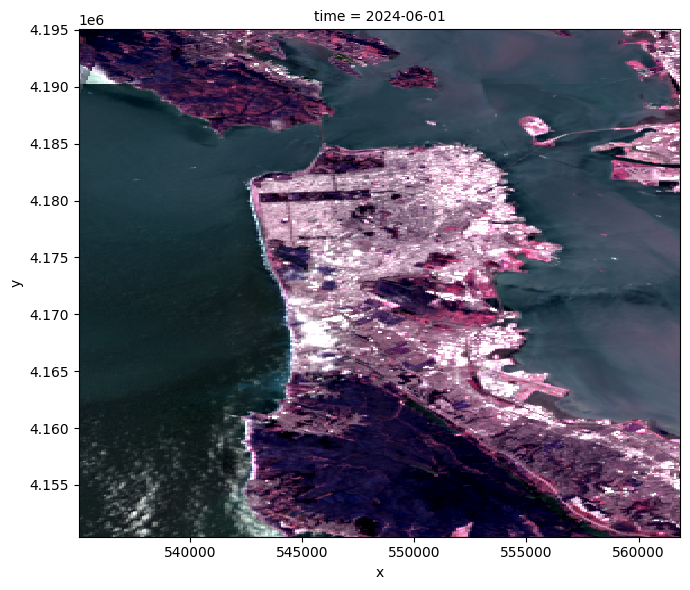

In [19]:
rgb_.plot.imshow(row="time", rgb="band", robust=True, size=6);

Saved: monthly_cogs/monthly_rgb_2024-06.tif


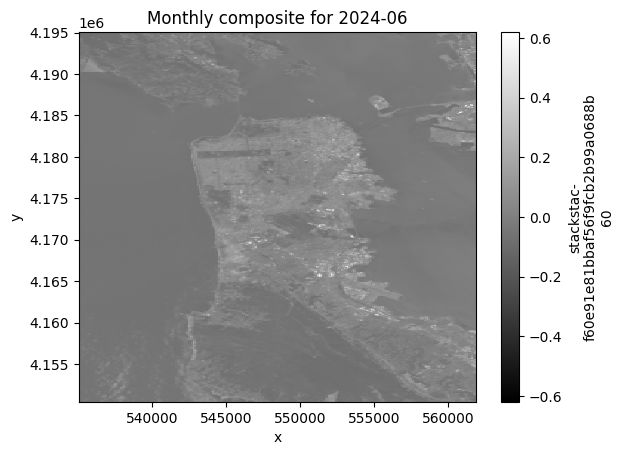

In [13]:
import os
import matplotlib.pyplot as plt

# Compute monthly median composite from time-band stack
monthly_rgb = stack.resample(time="MS").median(dim="time")

# Write CRS
monthly_rgb = monthly_rgb.rio.write_crs("EPSG:32610", inplace=True)

# Create output directory
os.makedirs("monthly_cogs", exist_ok=True)

# Loop through each monthly composite and save as Cloud Optimized GeoTIFF
with ProgressBar():
    for i, timestamp in enumerate(monthly_rgb.time.values):
        month_data = monthly_rgb.sel(time=timestamp)
        month_data = month_data.transpose("band", "y", "x")

        tstr = np.datetime_as_string(timestamp, unit='M')
        outfile = f"monthly_cogs/monthly_rgb_{tstr}.tif"

        month_data.rio.to_raster(outfile, driver="COG", compress="deflate")
        print(f"Saved: {outfile}")

# Visualize the first monthly composite layer
layer_to_plot = 0
monthly_rgb.isel(time=layer_to_plot, band=0).plot(cmap='gray')
plt.title(f"Monthly composite for {np.datetime_as_string(monthly_rgb.time[layer_to_plot].values, unit='M')}")
plt.show()

In [ ]:
import rioxarray as rxr

# Stack 'time' and 'band' dimensions into a single dimension 'z'
stack_flattened = stack.stack(z=("time", "band"))

# Reorder dimensions explicitly to ('z', 'y', 'x')
stack_flattened = stack_flattened.transpose('z', 'y', 'x')

# Assign CRS explicitly
stack_flattened = stack_flattened.rio.write_crs("EPSG:32610", inplace=True)

# Save as GeoTIFF
output_file = "stacked_full_content.tif"
stack_flattened.rio.to_raster(output_file)

print(f"Complete GeoTIFF exported successfully to {output_file}")


In [ ]:
import rioxarray as rxr

# Stack 'time' and 'band' dimensions into a single dimension 'z'
stack_flattened = stack.stack(z=("time", "band"))

# Reorder dimensions explicitly to ('z', 'y', 'x')
stack_flattened = stack_flattened.transpose('z', 'y', 'x')

# Assign CRS explicitly
stack_flattened = stack_flattened.rio.write_crs("EPSG:32610", inplace=True)




In [ ]:
from matplotlib import pyplot as plt

# Save as GeoTIFF
layer_to_plot = 0  # You can adjust this index to visualize different layers
stack_flattened.isel(z=layer_to_plot).plot(cmap='viridis')
plt.title(f"Visualization of stacked layer {layer_to_plot}")
plt.show()

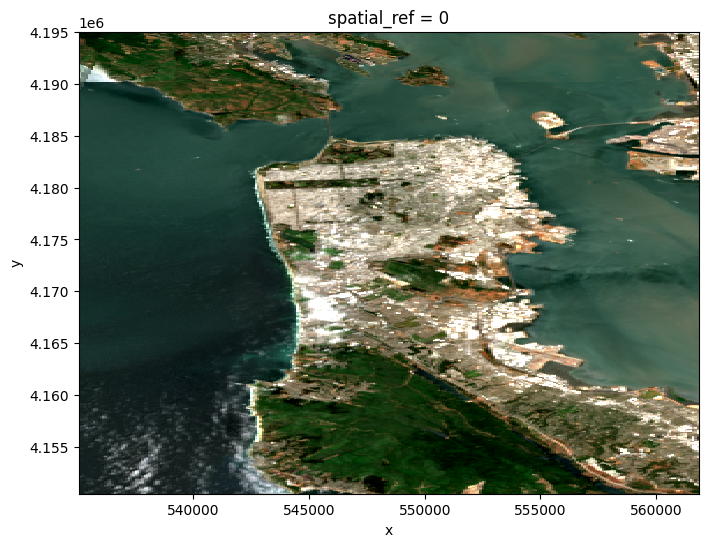

In [17]:
import rioxarray as rxr      # uses rasterio under the hood
import matplotlib.pyplot as plt

# 1️⃣ read the file (dims → band, y, x)
da = rxr.open_rasterio("/pipeline/monthly_cogs/monthly_rgb_2024-06.tif")

# 2️⃣ give the bands friendly names so xarray knows RGB order
# da = da.assign_coords(band=["red", "green", "blue"])

# 3️⃣ plot – tell xarray that the "band" dim is RGB
# da.plot.imshow(rgb="band", robust=True, size=6)
# plt.show()

da.plot.imshow(rgb="band", robust=True, size=6);
